In [1]:
from ultralytics import YOLO
from ultralytics import SAM
import matplotlib.pyplot as plt
import numpy as np
import imageio
import torch
import torchvision
from PIL import Image
import urllib.request
import cv2

from PIL import Image
from ipywidgets import Button, Output, Dropdown, IntSlider, Checkbox, VBox, HBox
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

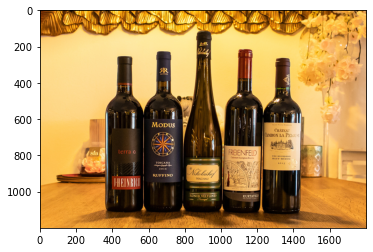

In [2]:
#url = 'https://www.vinothek-nagele.at/wp-content/uploads/2021/08/Titelbild_gross.jpg'
#urllib.request.urlretrieve(url, "img.png")
img = Image.open('object_input1.png')
img_np = None
global img_np
img_np = np.array(img)
plt.imshow(img)

<IPython.core.display.Javascript object>


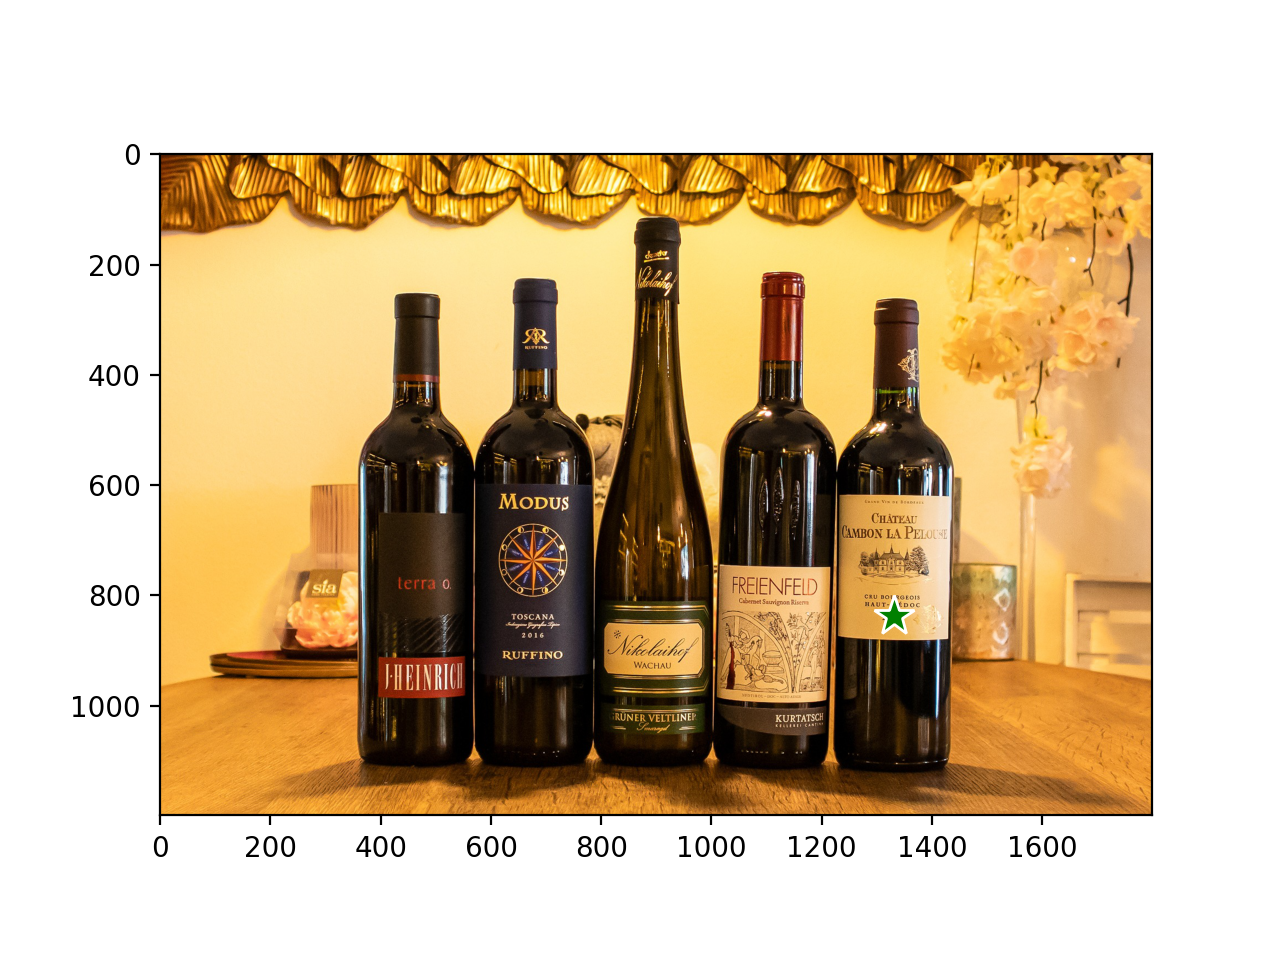

Button(description='Submit', style=ButtonStyle())

Output()

In [3]:
%matplotlib notebook


# Ensure the following paths and settings are correct
CHECKPOINT_PATH = '/Users/robin/Documents/Studium/WInfo_Master/Semester_3/ERASMUS/INF573/Project/UploadCode/sam_vit_b_01ec64.pth'  # Maybe set the correct path !!! Crucial so download the checkpoint of the model: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_TYPE = "vit_b"


# Global storage for the selected coordinates, current marker, and selected cutout
selected_point = None
current_marker = None
selected_cutout = None
selected_mask = None


# Initialize the SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)
mask_predictor.set_image(img_np)


# Load and display the image
fig, ax = plt.subplots()
ax.imshow(img_np)

# Event handler for mouse click on the image
def onclick(event):
    global selected_point, current_marker
    ix, iy = event.xdata, event.ydata
    selected_point = (ix, iy)

    # Remove the previous marker if it exists
    if current_marker is not None:
        current_marker.remove()

   # Draw a green star with white border at the clicked position
    current_marker = ax.plot(ix, iy, '*', color='green', markersize=15, markeredgecolor='white', markeredgewidth=1)[0]
    fig.canvas.draw()

# Add click event to the image
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Button and output widget for submitting point selection
button = Button(description="Submit")
output = Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        if selected_point is not None:
            # Convert the point to the required format for the model
            input_point = np.array([selected_point])
            input_label = np.array([1])  # Assumed label, adjust if necessary

            # Predict the segmentation mask at this point
            global masks
            masks, scores, logits = mask_predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=True,
            )
            
           # Output the number of predicted masks
            num_masks = len(masks)

            # Display each predicted mask
            if masks.size > 0:
                global cutouts   # Store cutouts for later access
                cutouts = []
                #output_masks = []
                for i, mask in enumerate(masks):
                    mask_expanded = np.expand_dims(mask > 0.5, axis=-1)
                    print(mask_expanded.shape)
                    # Make a mask of the picture
                    masked_image = np.where(mask_expanded, img_np, 0)

                    # Find the bounding box of the mask 
                    rows = np.any(mask, axis=1)
                    cols = np.any(mask, axis=0)
                    y_min, y_max = np.where(rows)[0][[0, -1]]
                    x_min, x_max = np.where(cols)[0][[0, -1]]

                    # Cutout the relevant area 
                    cutout = masked_image[y_min:y_max+1, x_min:x_max+1]

                    cutouts.append(cutout)
                    plt.figure()
                    plt.imshow(cutout)
                    plt.title(f'Cutout {i}')
                    plt.show()
                    
                # Create and display dropdown menu
                global dropdown
                dropdown = Dropdown(options=[f'Cutout {i}' for i in range(len(masks))], description='Choose Cutout:')
                display(dropdown)
                
                display(submit_dropdown_button)
                display(selected_cutout_output)
        else:
            print("No selcted point.")

display(button)
display(output)

button.on_click(on_button_clicked)

# Button for choosing a cutout from dropdown menu
submit_dropdown_button = Button(description="Choose Cutout")
selected_cutout_output = Output()

def on_submit_dropdown_clicked(b):
    with selected_cutout_output:
        selected_cutout_output.clear_output()
        if dropdown.value is not None:
            # Extract the index from the dropdown selection
            selected_index = int(dropdown.value.split()[-1])  
            global selected_cutout, selected_mask
            selected_cutout = cutouts[selected_index]
            selected_mask = masks[selected_index]
            selected_mask = np.array([selected_mask])
            selected_mask = selected_mask.astype(float)
            selected_mask = selected_mask.squeeze()


submit_dropdown_button.on_click(on_submit_dropdown_clicked)




<IPython.core.display.Javascript object>


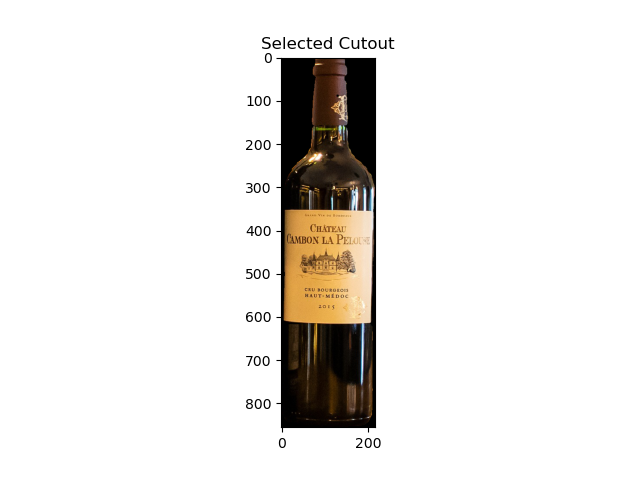

(856, 216, 3)


In [4]:
# Just to check the cutout
plt.figure()
plt.imshow(selected_cutout)
plt.title(f'Selected Cutout')
plt.show()
print(selected_cutout.shape)

(2385, 3000, 3)


<IPython.core.display.Javascript object>


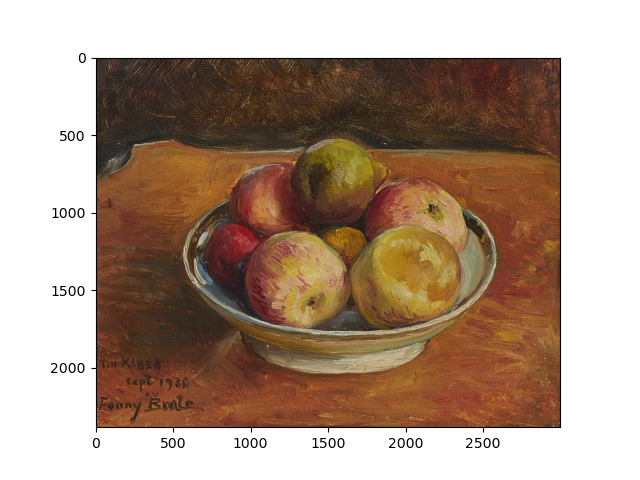

In [5]:
#Loading of the Background image 
#url_background = 'https://www.metropol.se/images/oljemalning,_fanny_brate_(1861-1940),_sverige_sig/%7BCB89E1E5-369A-4F7E-8F7D-BEA61C43BA84%7D/0/1305_1003_oljemalning'
                
#urllib.request.urlretrieve(url_background, "img_bg.png")

img_bg = Image.open('img_bg_input1.png')

img_bg = np.array(img_bg)
print(img_bg.shape)
plt.figure()
plt.imshow(img_bg)
plt.show()

In [6]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)


mask_generator = SamAutomaticMaskGenerator(sam)

# Generate segmentation mask
output_mask = mask_generator.generate(img_bg)
print(output_mask)

[{'segmentation': array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 1762946, 'bbox': [0, 0, 2999, 768], 'predicted_iou': 1.0150693655014038, 'point_coords': [[1265.625, 37.265625]], 'stability_score': 0.9687627553939819, 'crop_box': [0, 0, 3000, 2385]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 364522, 'bbox': [1634, 1087, 720, 654], 'predicted_iou': 0.9940

In [ ]:
# Function that inputs the output and plots image and mask
def show_output(result_dict,axes=None):
     if axes:
        ax = axes
     else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
     sorted_result = sorted(result_dict, key=(lambda x: x['area']),      reverse=True)
     # Plot for each segment area
     for val in sorted_result:
        mask = val['segmentation']
        img = np.ones((mask.shape[0], mask.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, mask*0.5)))
            
_,axes = plt.subplots(1,2)
axes[0].imshow(img_bg)
show_output(output_mask, axes[1])

<IPython.core.display.Javascript object>


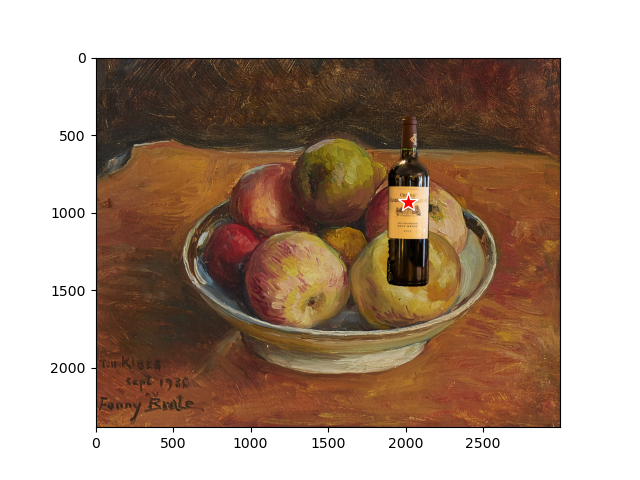

Button(description='Update Cutout', style=ButtonStyle())

Output()

In [7]:
%matplotlib notebook

# Displaying the background image# Anzeigen des Hintergrundbildes
fig_new, ax_new = plt.subplots()
ax_new.imshow(img_bg)

# Global variables for storing mouse click coordinates
new_click_coordinates = None
new_current_marker = None
new_mask = None

# Event handler for mouse click on the new image
def on_new_image_click(event):
    global new_click_coordinates, new_current_marker
    ix, iy = event.xdata, event.ydata
    new_click_coordinates = (ix, iy)
    print(f'Clicked coordinates: x={ix}, y={iy}')

    if new_current_marker is not None:
        new_current_marker.remove()

    new_current_marker = ax_new.plot(ix, iy, '*', color='red', markersize=15, markeredgecolor='white', markeredgewidth=1)[0]
    fig_new.canvas.draw()

# Connect the mouse click event to the function
cid_new = fig_new.canvas.mpl_connect('button_press_event', on_new_image_click)



# Initialize sliders for width and height with the original cutout size
original_width, original_height, _ = selected_cutout.shape
#original_width_mask, original_height_mask = selected_mask.shape
width_slider = IntSlider(value=original_width, min=20, max=1200, step=1, description='Width:')
height_slider = IntSlider(value=original_height, min=20, max=1200, step=1, description='Height:')

# Global variable for the original aspect ratio
original_aspect_ratio = original_height / original_width




# Checkbox to lock the aspect ratio, default is checked (True)
lock_aspect_ratio = Checkbox(value=True, description='Lock aspect ratio')

# Function to enable/disable automatic height adjustment based on the aspect ratio
def toggle_lock_aspect_ratio(change):
    if change['new']:  # If aspect ratio is locked
        # Automatic Highsclaing based on aspect ratio
        height_slider.value = int(width_slider.value * original_aspect_ratio)
        height_slider.disabled = True
    else:  # If aspect ratio is free
        # Free hight adjuster
        height_slider.disabled = False

lock_aspect_ratio.observe(toggle_lock_aspect_ratio, names='value')

# Adjust width function now only adjusts height when the aspect ratio is locked
def adjust_width(change):
    if change['name'] == 'value' and lock_aspect_ratio.value:
        # Berechnen des neuen Höhenwerts basierend auf dem Seitenverhältnis
        height_slider.value = int(change['new'] * original_aspect_ratio)

width_slider.observe(adjust_width, names='value')

# Initial call to set the height based on the aspect ratio when the lock_aspect_ratio is first set
toggle_lock_aspect_ratio({'new': lock_aspect_ratio.value})


# Create a rotation slider
rotation_slider = IntSlider(value=0, min=0, max=360, step=1, description='Rotation:')

# Combine the widgets in a vertical box layout
slider_box = VBox([
    HBox([width_slider, lock_aspect_ratio]),
    height_slider,
    rotation_slider
])

display(slider_box)


# Button to update the cutout
update_button = Button(description="Update Cutout")
update_output = Output()


def on_update_button_clicked(b):
    global selected_cutout, new_mask
    with update_output:
        update_output.clear_output()
        if new_click_coordinates is not None and selected_cutout is not None:
            new_width = width_slider.value
            new_height = height_slider.value
            rotation_angle = rotation_slider.value

            # Resize the cutout
            resized_cutout = resize_cutout(selected_cutout, (new_height, new_width))

            # Rotate the cutout
            rotated_cutout = rotate_cutout(resized_cutout, rotation_angle)

            # Overlay the processed cutout on the new image
            overlay_cutout(img_bg, rotated_cutout, new_click_coordinates)
            
            # Update the mask with the new cutout
            new_mask = create_precise_float_mask(img_bg, rotated_cutout, new_click_coordinates)
        else:
            print("Cutout not selected or coordinates not set.")
update_button.on_click(on_update_button_clicked)
display(update_button, update_output)

    


# Functions for resizing and placing the cutout
def resize_cutout(cutout, new_size):
    cutout_image = Image.fromarray(cutout)
    resized_cutout = cutout_image.resize(new_size, Image.ANTIALIAS)
    return np.array(resized_cutout)


def rotate_cutout(cutout, angle):
    """Rotiert das Cutout um den angegebenen Winkel."""
    cutout_image = Image.fromarray(cutout)
    rotated_cutout = cutout_image.rotate(angle, expand=True)
    return np.array(rotated_cutout)

def create_precise_float_mask(background, cutout, coordinates):
    mask_height, mask_width, _ = background.shape
    float_mask = np.zeros((mask_height, mask_width))  # 2D-Maske

    center_x, center_y = int(coordinates[0]), int(coordinates[1])
    cutout_height, cutout_width, _ = cutout.shape

    for x in range(cutout_width):
        for y in range(cutout_height):
            if not np.array_equal(cutout[y, x], [0, 0, 0]):  
                mask_x = center_x + x - cutout_width // 2
                mask_y = center_y + y - cutout_height // 2
                if 0 <= mask_x < mask_width and 0 <= mask_y < mask_height:
                    float_mask[mask_y, mask_x] = 1  

    return float_mask


def overlay_cutout(background, cutout, coordinates):
    global pasted_img
    center_x, center_y = int(coordinates[0]), int(coordinates[1])
    pasted_img = background.copy()
    height, width, _ = cutout.shape
    y_bg, x_bg, _ = pasted_img.shape
    
    # Making of new mask for placed cutout
    new_mask = np.zeros_like(pasted_img[:, :, 0])

    for x in range(width):
        for y in range(height):
            if not np.array_equal(cutout[y, x], [0, 0, 0]):
                new_y = y + center_y - height // 2
                new_x = x + center_x - width // 2
                if (0 <= new_y < y_bg) and (0 <= new_x < x_bg):
                    pasted_img[new_y, new_x, :] = cutout[y, x, :]

    plt.imshow(pasted_img)
    plt.show()
    
    

<IPython.core.display.Javascript object>


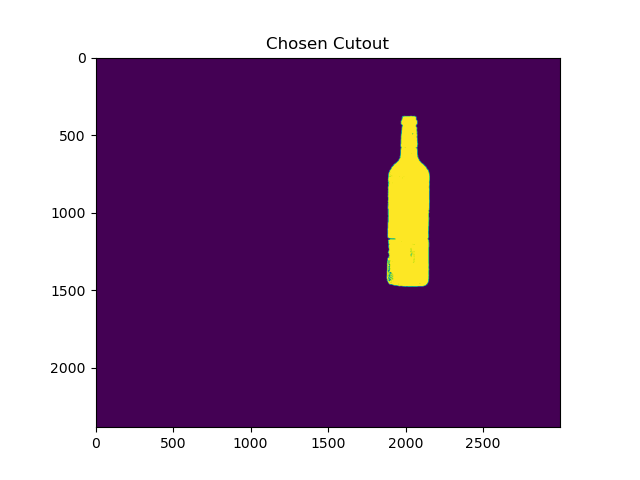

(2385, 3000)


In [8]:
#print(new_mask)
# Just to check the cutout. Can be thrown out later 
plt.figure()
plt.imshow(new_mask)
plt.title(f'Chosen Cutout')
plt.show()
print(new_mask.shape)

In [9]:
def exist_intersection(img1_mask, img2_mask):

    if np.sum(img1_mask * img2_mask) !=0:
        return True
    else:
        return False

In [10]:
#extract masks
sorted_result = sorted(output_mask, key=(lambda x: x['area']), reverse=True)
bg_masks = np.zeros((len(sorted_result), img_bg.shape[0],img_bg.shape[1], ))
for i, val in enumerate(sorted_result):
  bg_masks[i] = val['segmentation']

bg_masks[1].shape
print(sorted_result[3]['segmentation'].dtype)

bool


<IPython.core.display.Javascript object>


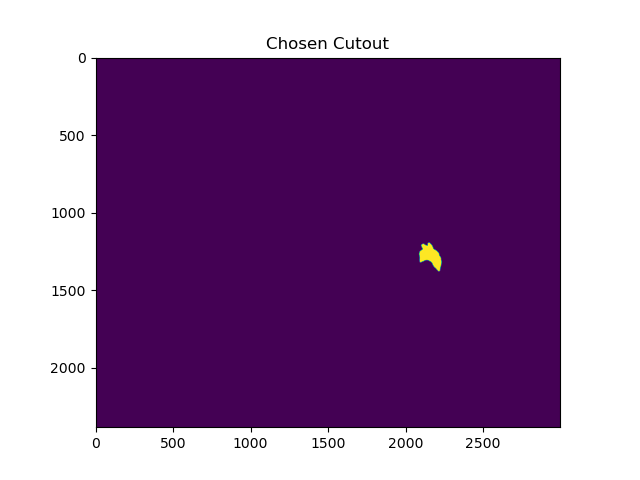

In [11]:
intersect_labels = []
intersecting_masks = []
for i in range(bg_masks.shape[0]):
  intersect_labels.append(exist_intersection(new_mask, bg_masks[i]))
  if exist_intersection(new_mask, bg_masks[i]) == True:
    intersecting_masks.append(bg_masks[i])
plt.figure()
plt.imshow(intersecting_masks[3])
plt.title(f'Chosen Cutout')
plt.show()
#imshow(intersecting_masks[1], intersecting_masks[0])

<IPython.core.display.Javascript object>


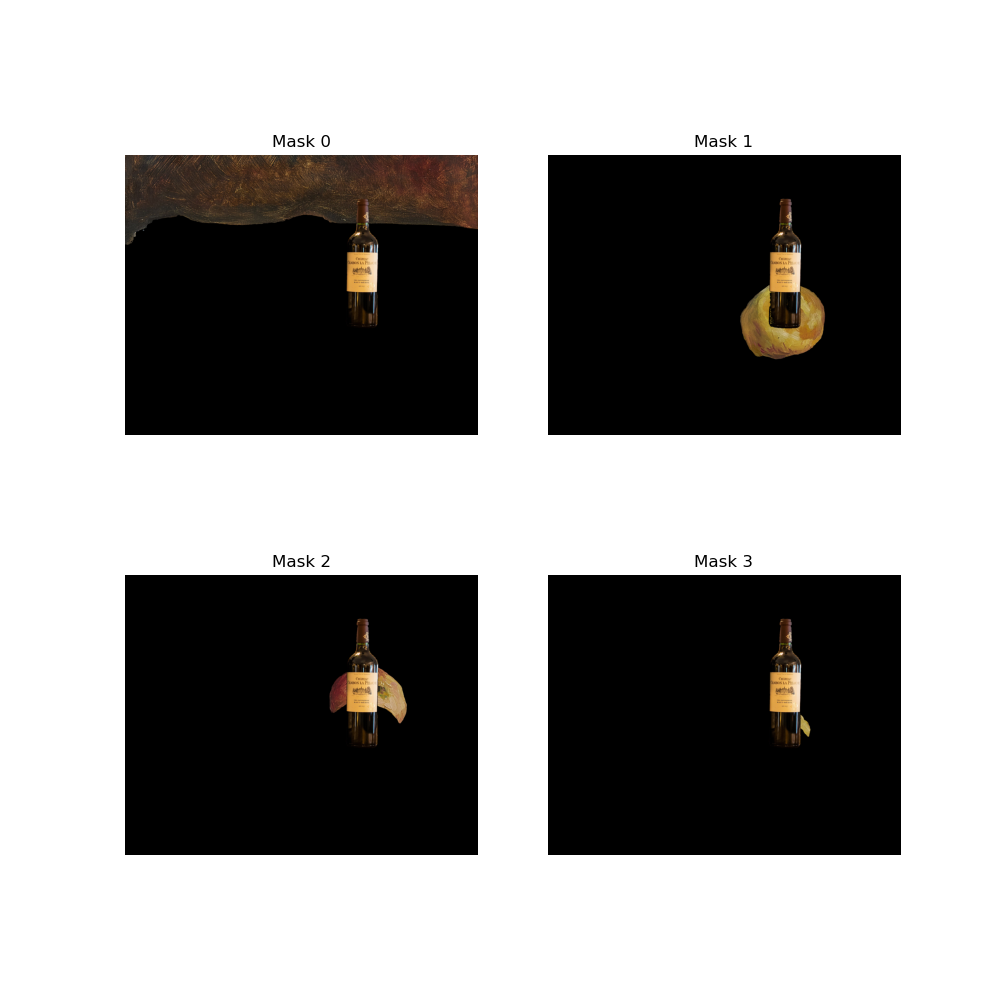

Checkbox(value=False, description='Mask 0')

Checkbox(value=False, description='Mask 1')

Checkbox(value=False, description='Mask 2')

Checkbox(value=False, description='Mask 3')

Button(description='Update Values', style=ButtonStyle())

Updated values: [False, True, True, True]


In [12]:
num_intersection = intersect_labels.count(True)
masked_bg_with_obj = np.zeros((num_intersection, pasted_img.shape[0], pasted_img.shape[1], pasted_img.shape[2]))
img_bg = img_bg/255
pasted_img = pasted_img/255
masked_obj = pasted_img * new_mask[:,:, None]

j = 0
for i, val in enumerate(intersect_labels):
  if val == True:
    masked_bg_with_obj[j] = img_bg * bg_masks[i][:, :, None]
    masked_bg_with_obj[j][new_mask == 1] = masked_obj[new_mask == 1]
    j += 1

# Example: Generate some random images
num_images = num_intersection


# Determine the grid layout based on the number of images
rows = int(np.ceil(np.sqrt(num_images)))
cols = int(np.ceil(num_images / rows))

# Plot the images in a grid
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < num_images:
            axes[i, j].imshow(masked_bg_with_obj[index], cmap='gray')  # Assuming grayscale images
            axes[i, j].axis('off')
            axes[i, j].set_title(f'Mask {index}')

plt.show()

num_checkboxes = num_intersection
initial_values = [False] * num_checkboxes

# Create checkboxes
checkboxes = [Checkbox(value=value, description=f'Mask {i}') for i, value in enumerate(initial_values)]

# Display checkboxes
display(*checkboxes)

# Variable to store the updated values
updated_values = initial_values

# Function to update the variable when checkboxes change
def update_values(change):
    global updated_values
    updated_values = [checkbox.value for checkbox in checkboxes]

# Attach the function to observe checkbox changes
for checkbox in checkboxes:
    checkbox.observe(update_values, names='value')

# Display a button to trigger the update
update_button = Button(description="Update Values")

# Function to be called on button click
def on_button_click(b):
    print("Updated values:", updated_values)

# Attach the function to the button click event
update_button.on_click(on_button_click)

# Display the button
display(update_button)

<IPython.core.display.Javascript object>


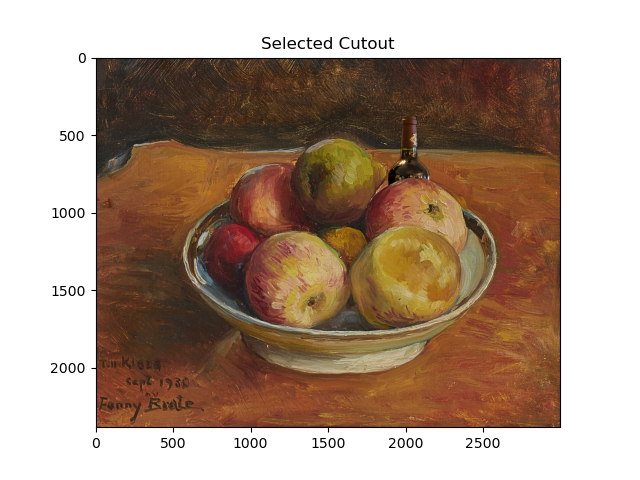

In [13]:
user_input=updated_values
temp_masked_obj = masked_obj.copy()
new_pasted_img = pasted_img.copy()
new_obj_mask = new_mask.copy()
for i in range(len(user_input)):
  masked_bg = img_bg * intersecting_masks[i][:, :, None]
  if user_input[i] == True:#move obj back to the background
    temp_masked_obj[intersecting_masks[i]==1] = masked_bg[intersecting_masks[i]==1]
    #make final img
    new_pasted_img[intersecting_masks[i]==1] = temp_masked_obj[intersecting_masks[i]==1]
    #make the intersection value as 0
    bg_masks_reversed = np.where(intersecting_masks[i] == 1, 0, 1)
    new_obj_mask = bg_masks_reversed * new_obj_mask

plt.figure()
plt.imshow(new_pasted_img)
plt.title(f'Selected Cutout')
plt.show()

In [ ]:
#make mask wider
kernel = np.ones((3, 3), np.uint8)
dilated_mask = cv2.dilate(new_obj_mask, kernel, iterations = 10)

dilated_masked_img = new_pasted_img * dilated_mask[:,:,None]

In [ ]:
img_bg = (img_bg*255).astype(np.uint8)
new_pasted_img =(new_pasted_img*255).astype(np.uint8)
dilated_mask = (dilated_mask*255).astype(np.uint8)
new_obj_mask = (new_obj_mask*255).astype(np.uint8)

In [ ]:
img_bg = Image.fromarray(img_bg).save("img_bg.jpg")
new_pasted_img = Image.fromarray(new_pasted_img).save("new_pasted_img.jpg")
dilated_mask = Image.fromarray(dilated_mask).save("dilated_mask.jpg")
new_obj_mask = Image.fromarray(new_obj_mask).save("new_obj_mask.jpg")

In [ ]:
!python baseline.py